In [3]:
import pandas  as pd
import seaborn as sns
from sklearn.discriminant_analysis import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import os
from utils import run_kfold_eval, calculate_metric
import optuna
import time
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
import joblib
from pathlib import Path

In [4]:
DATA_FOLDER = "../data"
TRAIN_FEATURES = DATA_FOLDER + '/train_features2.xlsx'
TRAIN_LABELS = DATA_FOLDER + "/train_labels2.xlsx"
TEST_FEATURES = DATA_FOLDER + "/test_features2.xlsx"
TEST_LABELS = DATA_FOLDER + "/test_labels2.xlsx"
OUTPUT_PATH = '../output/ridge'

TRAINING_OUTPUT_FILE = '../output/train_predictions.xlsx'
TEST_OUTPUT_FILE = '../output/test_predictions.xlsx'
SHEET_NAME = "ridge"

In [5]:
# create path
output_dir = Path(OUTPUT_PATH)
output_dir.mkdir(parents=True, exist_ok=True)

In [6]:
train_features = pd.read_excel(TRAIN_FEATURES)
train_labels = pd.read_excel(TRAIN_LABELS)
test_features = pd.read_excel(TEST_FEATURES)
test_labels = pd.read_excel(TEST_LABELS)

In [7]:
test_features.head()

,coupon rate,SP500 MD,Average daily 1-year SP500 return,Ratio to MA,US Corporate Bond Yield Spread,US Corporate Bond Yield Spread(3-5 year),US Corporate Bond Yield Spread(5-7 year),US Corporate Bond Yield Spread(7-10 year),US Corporate Bond Yield Spread(10+ year),US Generic Govt 3 Month Yield,...,event_type_subcategory_sum_Missing Coupon payment only,event_type_subcategory_sum_Missing Interest payment,event_type_subcategory_sum_Missing Loan payment,event_type_subcategory_sum_Missing Principal payment,event_type_subcategory_sum_Others,event_type_subcategory_sum_Pre-Negotiated Chapter 11,event_type_subcategory_sum_Protection,event_type_subcategory_sum_Receivership,event_type_subcategory_sum_Rehabilitation,event_type_subcategory_sum_Restructuring
0,3.125,-122.39680,-0.001341,1.116103,396.408936,399.031738,455.0625,383.612488,341.675812,0.1734,...,False,False,False,False,False,False,False,False,False,False
1,15.000,156.01912,0.000790,6.372588,107.083778,76.414360,118.2482,113.403519,147.756165,0.0253,...,False,False,False,False,False,False,False,False,False,False
2,0.000,-451.10824,-0.002033,43.914617,637.607544,689.770996,683.3611,589.969666,529.166992,0.0406,...,False,False,False,True,False,False,False,False,False,False
3,5.875,-751.22120,-0.000435,74.783398,153.653778,129.425842,158.3252,172.708054,187.147980,1.4908,...,False,False,False,False,False,False,False,False,False,False
4,10.000,55.69036,0.000712,-28.522133,152.290619,148.385330,222.1811,142.140915,159.624313,0.0763,...,False,False,False,False,False,False,False,False,False,False


In [8]:
print(train_features.shape)
print(train_labels.shape)
print(test_features.shape)
print(test_labels.shape)

(1293, 317)
(1293, 1)
(432, 317)
(432, 1)


In [9]:
feature_list = train_features.columns
# category_feature_key = ['currency', 'seniorioty_adj', 'domicile_country',	'exchange_country',	'Industry_sector',	'Industry_group',	'Industry_subgroup', 'event_type',
#                  'event_type_subcategory_sum', 'defaulted_in_last_6_months']
# category_features = [i for i in feature_list if any(sub in i for sub in category_feature_key)]
category_features = train_features.select_dtypes(include=['int', 'bool']).columns
non_category_features = [i for i in feature_list if i not in category_features]

print(len(category_features))
print(len(non_category_features))

164
153


In [10]:
category_features

Index(['defaulted_in_last_5_years', 'defaulted_in_last_6_months',
       'currency_CAD', 'currency_CHF', 'currency_CNY', 'currency_EUR',
       'currency_GBP', 'currency_HKD', 'currency_INR', 'currency_ISK',
       ...
       'event_type_subcategory_sum_Missing Coupon payment only',
       'event_type_subcategory_sum_Missing Interest payment',
       'event_type_subcategory_sum_Missing Loan payment',
       'event_type_subcategory_sum_Missing Principal payment',
       'event_type_subcategory_sum_Others',
       'event_type_subcategory_sum_Pre-Negotiated Chapter 11',
       'event_type_subcategory_sum_Protection',
       'event_type_subcategory_sum_Receivership',
       'event_type_subcategory_sum_Rehabilitation',
       'event_type_subcategory_sum_Restructuring'],
      dtype='object', length=164)

In [11]:
# Normalize the data
# Prepare the ColumnTransformer

scaler = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), non_category_features)   # StandardScaler()
    ],
    remainder='passthrough'  # Leave categorical features untouched
)

In [12]:
def objective(trial):

    alpha = trial.suggest_float('alpha', 0.01, 100, log=True)
    
    # Create the pipeline with the current hyperparameters
    pipeline = Pipeline([
        ('scaler', scaler),
        ('lasso', Ridge(alpha=alpha, random_state=42))
    ])
    
    score = cross_val_score(pipeline, train_features, train_labels['rr1_30'].to_numpy(), cv=5, scoring='neg_mean_squared_error', n_jobs=-1).mean()
    return score

In [10]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, show_progress_bar=True)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2025-03-31 12:35:09,836] A new study created in memory with name: no-name-3f33a49e-b2ca-4d49-bb20-784eb636f1d3


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-03-31 12:35:18,897] Trial 0 finished with value: -0.07974612543217628 and parameters: {'alpha': 10.221032993029436}. Best is trial 0 with value: -0.07974612543217628.
[I 2025-03-31 12:35:21,509] Trial 1 finished with value: -0.08221598624101718 and parameters: {'alpha': 39.329493588301986}. Best is trial 0 with value: -0.07974612543217628.
[I 2025-03-31 12:35:21,818] Trial 2 finished with value: -0.07978721560450366 and parameters: {'alpha': 10.50628248839988}. Best is trial 0 with value: -0.07974612543217628.
[I 2025-03-31 12:35:25,025] Trial 3 finished with value: -0.08831765488798136 and parameters: {'alpha': 0.2473058377261613}. Best is trial 0 with value: -0.07974612543217628.
[I 2025-03-31 12:35:25,275] Trial 4 finished with value: -0.10148199420638002 and parameters: {'alpha': 0.01599216480676018}. Best is trial 0 with value: -0.07974612543217628.
[I 2025-03-31 12:35:25,581] Trial 5 finished with value: -0.0805847636768771 and parameters: {'alpha': 17.095747069320282}. B

In [22]:
study.best_params

{'alpha': 2.91163374515504}

In [13]:
start_time = time.time()

# Get the best hyperparameters
# best_params = study.best_params
best_params = {'alpha': 2.91163374515504}

# Train the final model on the entire training data
pipeline = Pipeline([
        ('scaler', scaler),
        ('lasso', Ridge(random_state=42, **best_params))
    ])

pipeline.fit(train_features, train_labels.to_numpy())

elapsed_time = time.time() - start_time
print(f"Training time: {elapsed_time:.3f} seconds")

# do prediction
predictions = pipeline.predict(test_features)


Training time: 1.026 seconds


In [14]:

# save metrics
mae, mape, rmse, rsqr = calculate_metric(predictions, test_labels['rr1_30'].to_numpy())
print(f"Val average mean absolute error: {mae}")
print(f"Val average mean absolute percentage error: {mape}")
print(f"Val average root mean squared error: {rmse}")
print(f"Val average R2: {rsqr}")

Val average mean absolute error: 0.33661147576488304
Val average mean absolute percentage error: 392.4678560985871
Val average root mean squared error: 0.27654810642132177
Val average R2: 0.33231893486280606


In [16]:
train_predictions = pipeline.predict(train_features)
# save metrics
mae, mape, rmse, rsqr = calculate_metric(train_predictions, train_labels['rr1_30'].to_numpy())
print(f"Training average mean absolute error: {mae}")
print(f"Training average mean absolute percentage error: {mape}")
print(f"Training average root mean squared error: {rmse}")
print(f"Training average R2: {rsqr}")

Training average mean absolute error: 0.3298933422612936
Training average mean absolute percentage error: 4656.112156860046
Training average root mean squared error: 0.22347155896674292
Training average R2: 0.5396741916465466


In [19]:
# save train predictions
train_predictions_df = pd.DataFrame({"predictions": train_predictions.ravel()})
with pd.ExcelWriter(TRAINING_OUTPUT_FILE, mode='a', engine='openpyxl', if_sheet_exists='replace') as writer:
    # Write the new DataFrame to a new sheet
    train_predictions_df.to_excel(writer, sheet_name=SHEET_NAME, index=False)
    
# save test predictions
test_predictions_df = pd.DataFrame({"predictions": predictions.ravel()})
with pd.ExcelWriter(TEST_OUTPUT_FILE, mode='a', engine='openpyxl', if_sheet_exists='replace') as writer:
    # Write the new DataFrame to a new sheet
    test_predictions_df.to_excel(writer, sheet_name=SHEET_NAME, index=False)

In [26]:
# Save the best model (you could use joblib in a real scenario)
joblib.dump(pipeline, OUTPUT_PATH + '/ridge_model.pkl')

['../output/ridge/ridge_model.pkl']

In [34]:
pipeline

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['coupon rate', 'SP500 MD',
                                                   'Average daily 1-year SP500 '
                                                   'return',
                                                   'Ratio to MA',
                                                   'US Corporate Bond Yield '
                                                   'Spread',
                                                   'US Corporate Bond Yield '
                                                   'Spread(3-5 year)',
                                                   'US Corporate Bond Yield '
                                                   'Spread(5-7 year)',
                                                   'US Corporate Bond Yield '
                                                   'Spread(7-10 year)',
                                                   'US Corporate Bond Yield '...
                                                   'US Generic Govt 10 Year '
                                                   'Yield',
                                                   'marketcap',
                                                   'sector_domicile_dtd',
                                                   'sector_exchange_dtd',
                                                   'sector_dtd',
                                                   'PD_1_domicile_sector',
                                                   'PD_3_domicile_sector',
                                                   'PD_12_domicile_sector',
                                                   'PD_1_domicile_subsec',
                                                   'PD_3_domicile_subsec',
                                                   'PD_12_domicile_subsec',
                                                   'PD_1_exch_sector',
                                                   'PD_3_exch_sector',
                                                   'PD_12_exch_sector', ...])])),
                ('ridge', Ridge(alpha=2.91163374515504, random_state=42))])

In [36]:
# Get the model coefficients
coef = pipeline.named_steps['ridge'].coef_

In [37]:
new_feature_list = non_category_features + category_features.to_list()

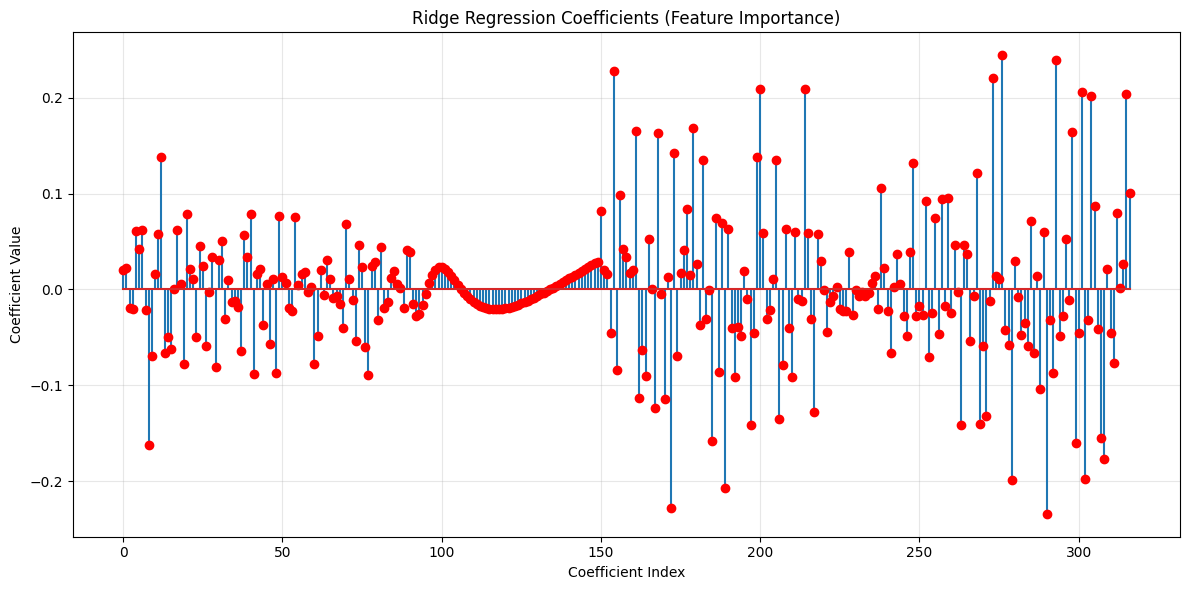

In [38]:
# Plot the coefficients
plt.figure(figsize=(12, 6))
plt.stem(range(len(coef)), coef, markerfmt='ro')
# plt.xticks(range(len(coef)), new_feature_list, rotation=90)
plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Value')
plt.title('Ridge Regression Coefficients (Feature Importance)')
plt.tight_layout()
plt.grid(True, alpha=0.3)

In [39]:
non_zero_coeff = []
non_zero_features = []
for index, value in enumerate(coef):
    if value == 0:
        continue
    non_zero_coeff.append(value)
    non_zero_features.append(new_feature_list[index])

In [40]:
### Feature importance 

# Create a DataFrame for better visualization
feature_importances = pd.DataFrame({
    'Feature': non_zero_features,
    'Importance': non_zero_coeff
})

# Sort the features by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=True)

In [41]:
feature_importances

,Feature,Importance
289,Industry_subgroup_Software,-0.234162
171,seniorioty_adj_Secured,-0.228606
188,domicile_country_Iceland,-0.207262
278,Industry_subgroup_Metals & Mining,-0.199029
301,event_type_subcategory_sum_Bankruptcy,-0.198282
...,...,...
199,domicile_country_South Korea,0.209489
272,Industry_subgroup_Industrial Support Services,0.221228
154,defaulted_in_last_6_months,0.228186
292,Industry_subgroup_Technology Services,0.239633


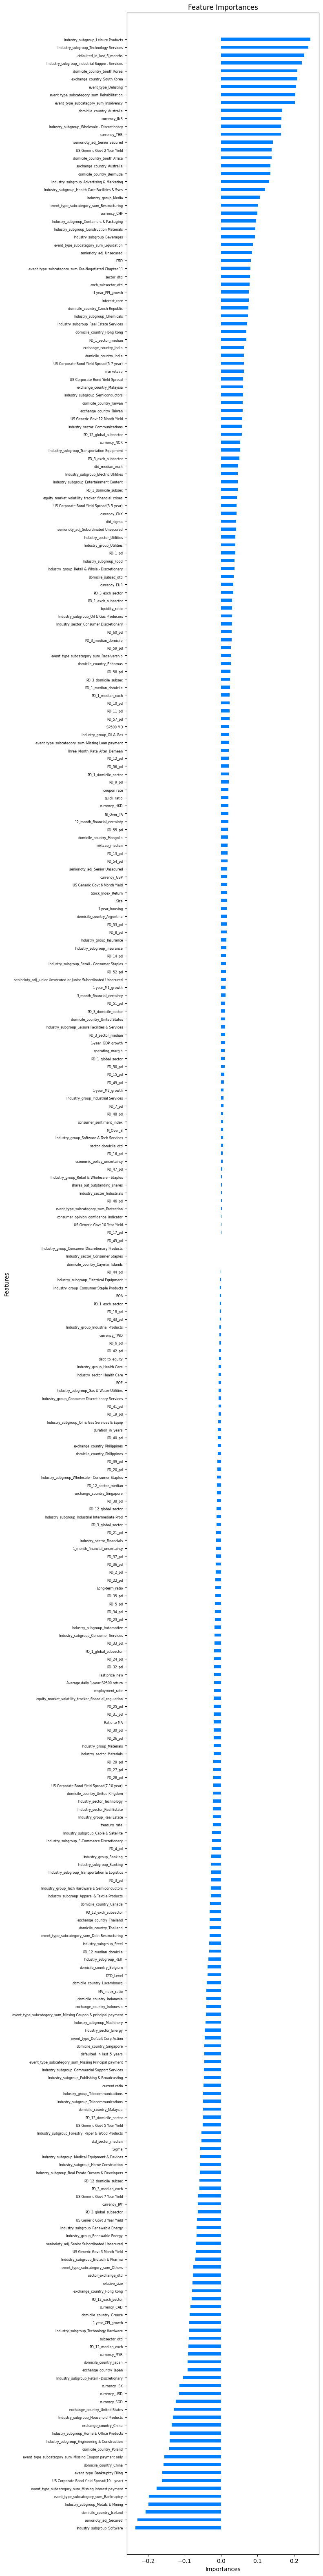

In [48]:
# Create a horizontal bar chart
plt.figure(figsize=(10, 6))  # Adjust the size of the plot as needed
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color=(0, 0.5, 1), height=0.4)  # Adjust the height for spacing
# Increase figure height to accommodate the spacing
plt.gcf().set_size_inches(10, max(2, len(feature_importances) * 0.2))

plt.ylabel('Features')  # Label for the y-axis
plt.xlabel('Importances')  # Label for the x-axis
plt.title('Feature Importances')  # Title of the plot
plt.margins(y=0.01) # Include margins adjustment to remove extra whitespace
plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
plt.yticks(fontsize='xx-small')
plt.savefig(os.path.join(OUTPUT_PATH,'feature_importance.png'))

plt.show()

5-fold CV

In [49]:
features = pd.concat([train_features, test_features], axis=0, ignore_index=True)
features

,coupon rate,SP500 MD,Average daily 1-year SP500 return,Ratio to MA,US Corporate Bond Yield Spread,US Corporate Bond Yield Spread(3-5 year),US Corporate Bond Yield Spread(5-7 year),US Corporate Bond Yield Spread(7-10 year),US Corporate Bond Yield Spread(10+ year),US Generic Govt 3 Month Yield,...,event_type_subcategory_sum_Missing Coupon payment only,event_type_subcategory_sum_Missing Interest payment,event_type_subcategory_sum_Missing Loan payment,event_type_subcategory_sum_Missing Principal payment,event_type_subcategory_sum_Others,event_type_subcategory_sum_Pre-Negotiated Chapter 11,event_type_subcategory_sum_Protection,event_type_subcategory_sum_Receivership,event_type_subcategory_sum_Rehabilitation,event_type_subcategory_sum_Restructuring
0,7.500,-117.46020,-0.000189,125.407139,177.213028,134.012054,198.8153,191.364395,223.346344,0.1983,...,True,False,False,False,False,False,False,False,False,False
1,6.000,166.38276,0.000768,-4.603446,101.613617,77.032829,123.3998,105.932022,139.111115,0.0355,...,False,False,False,False,False,False,False,False,False,False
2,11.000,119.85752,0.000678,-11.950380,104.545959,77.416649,129.4317,111.818001,139.717407,0.0101,...,False,False,False,False,False,False,False,False,False,False
3,9.125,653.51208,0.001638,-2.494861,90.736633,64.654129,95.3731,92.141212,121.666237,0.0152,...,False,False,False,False,False,False,False,False,False,False
4,9.250,231.89472,0.000664,4.823413,98.533821,68.759308,93.4174,107.424469,139.741165,1.2865,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1720,3.250,147.33344,0.000556,3.538252,128.976395,95.360374,138.8445,138.946106,172.733887,0.0000,...,False,False,False,False,False,False,False,False,False,False
1721,10.000,175.31656,0.000554,-4.067337,121.170998,92.879501,123.2500,131.104904,162.916901,0.7516,...,False,True,False,False,False,False,False,False,False,False
1722,7.450,315.81748,0.000747,8.604100,126.786606,89.018188,114.9728,131.522430,171.701096,0.0864,...,False,False,False,False,False,False,False,False,False,False
1723,0.500,31.75120,-0.000157,-4.373852,126.595230,105.460007,121.6212,147.382416,163.772141,4.8375,...,False,False,False,False,False,False,False,False,False,False


In [50]:
labels = pd.concat([train_labels, test_labels], axis=0, ignore_index=True)
labels

,rr1_30
0,0.082481
1,0.378845
2,0.836149
3,0.987208
4,1.021458
...,...
1720,0.471411
1721,0.823750
1722,0.241612
1723,0.762054


In [51]:
pipeline = Pipeline([
        ('scaler', scaler),
        ('lasso', Ridge(random_state=42, **best_params))
    ])
# pipeline.fit(train_features, train_labels)

In [52]:
train_preds, oof_preds, feat_importances, train_metrics, val_metrics = run_kfold_eval(features, labels.to_numpy(), n_folds=5, model=pipeline, model_params=None, output_path=OUTPUT_PATH, name="xgboost")

100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


In [53]:
# print test resuls
mae = 0
mape = 0
rmse = 0
rsqr = 0
i = 0

for key, value in train_metrics.items():
  if "mae" in key:
    i += 1
    mae += value

  if "mape" in key:
    mape += value

  if "rmse" in key:
    rmse += value

  if "rsqr" in key:
    rsqr += value

print(f"Training average mean absolute error: {mae/i}")
print(f"Training average mean absolute percentage error: {mape/i}")
print(f"Training average root mean squared error: {rmse/i}")
print(f"Training average R2: {rsqr/i}")

Training average mean absolute error: 0.17957090416940485
Training average mean absolute percentage error: 2692.6729131474153
Training average root mean squared error: 0.22859920361143232
Training average R2: 0.5247349940065454


In [54]:
# print test resuls
mae = 0
mape = 0
rmse = 0
rsqr = 0
i = 0

for key, value in val_metrics.items():
  if "mae" in key:
    i += 1
    mae += value

  if "mape" in key:
    mape += value

  if "rmse" in key:
    rmse += value

  if "rsqr" in key:
    rsqr += value

print(f"Test average mean absolute error: {mae/i}")
print(f"Test average mean absolute percentage error: {mape/i}")
print(f"Test average root mean squared error: {rmse/i}")
print(f"Test average R2: {rsqr/i}")

Test average mean absolute error: 0.20796835586413853
Test average mean absolute percentage error: 3244.2744367691826
Test average root mean squared error: 0.2778010536439296
Test average R2: 0.2944858028311562


In [ ]:
# print test resuls
mae = 0
mape = 0
rmse = 0
rsqr = 0
i = 0

for key, value in val_metrics.items():
  if "mae" in key:
    i += 1
    mae += value

  if "mape" in key:
    mape += value

  if "rmse" in key:
    rmse += value

  if "rsqr" in key:
    rsqr += value

print(f"Test average mean absolute error: {mae/i}")
print(f"Test average mean absolute percentage error: {mape/i}")
print(f"Test average root mean squared error: {rmse/i}")
print(f"Test average R2: {rsqr/i}")

Test average mean absolute error: 0.3207963004399647
Test average mean absolute percentage error: 3689.2855343450947
Test average root mean squared error: 0.26950622774099475
Test average R2: 0.3353713124884782
